✅ Successfully loaded data from: c:\code\NewsSentimentPricePredictor\data\raw_analyst_ratings.csv
Data shape: (1407328, 6)

First date values:
0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
Name: date, dtype: object

=== BASIC STATISTICS ===
Headline Lengths:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

Word Counts:
 count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: word_count, dtype: float64

=== PUBLISHER ANALYSIS ===
Top Publishers:
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF 

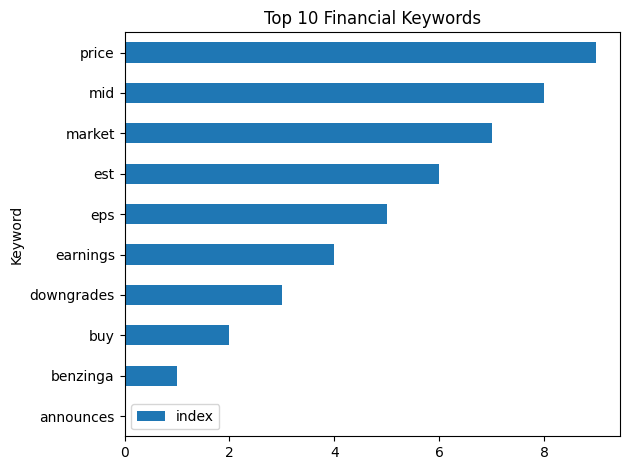


=== VISUALIZATIONS ===


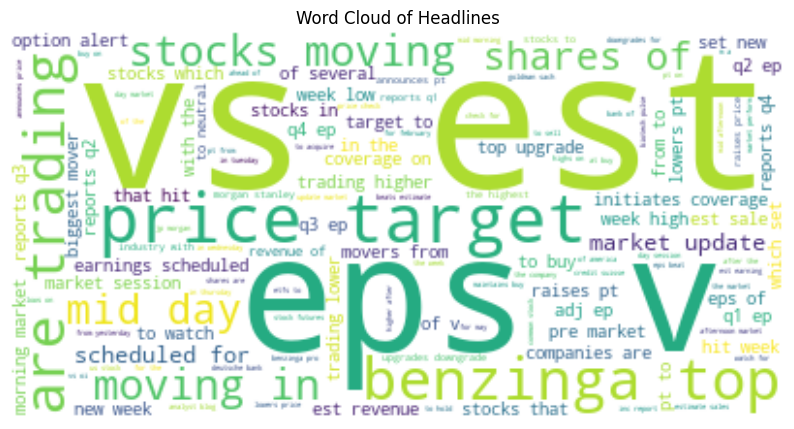

In [3]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Configure paths
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Import from src
from src.data_stats import compute_headline_lengths, headline_word_counts
from src.publisher_analysis import count_publishers, extract_top_keywords
from src.time_analysis import get_daily_article_counts, get_hourly_distribution
from src.visualize import plot_wordcloud

# Correct data path
data_path = os.path.join(project_root, "data", "raw_analyst_ratings.csv")

def robust_enrich_time_features(df):
    """Enhanced version that handles your specific datetime format"""
    try:
        # First try ISO8601 format
        df['date'] = pd.to_datetime(df['date'], format='ISO8601', errors='coerce')
        
        # For any remaining NaT values, try mixed format parsing
        if df['date'].isna().any():
            mask = df['date'].isna()
            df.loc[mask, 'date'] = pd.to_datetime(df.loc[mask, 'date'], format='mixed', errors='coerce')
        
        # Remove any remaining invalid dates
        df = df.dropna(subset=['date'])
        
        # Convert to NY timezone
        df['date'] = df['date'].dt.tz_convert('America/New_York')
        
        # Extract time features
        df['weekday'] = df['date'].dt.day_name()
        df['hour'] = df['date'].dt.hour
        df['is_market_hours'] = df['hour'].between(9, 16)  # NYSE hours
        df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])
        
        return df
    except Exception as e:
        print(f"⚠️ Time processing warning: {str(e)}")
        return df

try:
    # Load data
    df = pd.read_csv(data_path)
    print(f"✅ Successfully loaded data from: {data_path}")
    print(f"Data shape: {df.shape}")
    print("\nFirst date values:")
    print(df['date'].head(3))  # Show sample dates for verification
    
    # Verify required columns exist
    required_columns = {'headline', 'publisher', 'date'}
    missing_cols = required_columns - set(df.columns)
    if missing_cols:
        raise KeyError(f"Missing required columns: {missing_cols}")
    
    # 1. Descriptive statistics
    print("\n=== BASIC STATISTICS ===")
    print("Headline Lengths:\n", compute_headline_lengths(df))
    print("\nWord Counts:\n", headline_word_counts(df))
    
    # 2. Publisher Analysis
    print("\n=== PUBLISHER ANALYSIS ===")
    print("Top Publishers:\n", count_publishers(df))
    
    # 3. Time Analysis with robust parsing
    print("\n=== TEMPORAL ANALYSIS ===")
    df = robust_enrich_time_features(df)
    if 'hour' in df.columns:  # Only show if time features were added
        print("Market Hours Coverage: {:.1%} during trading hours".format(df['is_market_hours'].mean()))
        print("\nDaily Counts:\n", get_daily_article_counts(df).head())
        print("\nHourly Distribution (%):\n", get_hourly_distribution(df).head())
    else:
        print("⚠️ Time features not available - proceeding with other analyses")
    
    # 4. Text Analysis (with flexible handling)
    print("\n=== TEXT ANALYSIS ===")
    try:
        keywords_result = extract_top_keywords(df, n=20)
        
        # Handle both return formats
        if isinstance(keywords_result[0], tuple):
            print("\nTop Keywords with Counts:")
            for kw, count in keywords_result[:10]:
                print(f"{kw}: {count}")
            
            # Visualization with counts
            pd.DataFrame(keywords_result, columns=['Keyword', 'Count']) \
                .head(10) \
                .set_index('Keyword') \
                .plot(kind='barh', title='Top 10 Financial Keywords')
        else:
            print("\nTop Keywords:")
            for kw in keywords_result[:10]:
                print(kw)
            
            # Simple keywords visualization
            pd.Series(keywords_result[:10]).to_frame('Keyword') \
                .reset_index() \
                .plot(kind='barh', x='Keyword', title='Top 10 Financial Keywords')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Text analysis error: {str(e)}")
        if 'keywords_result' in locals():
            print("Sample output:", keywords_result[:2])
    
    # 5. Word Cloud Visualization
    print("\n=== VISUALIZATIONS ===")
    plot_wordcloud(df)
    
except FileNotFoundError:
    print(f"❌ Error: File not found at {data_path}")
except KeyError as e:
    print(f"❌ Missing data: {e}")
    print("Available columns:", df.columns.tolist())
except Exception as e:
    print(f"❌ Unexpected error: {str(e)}")